In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import stats, signal, optimize
from tqdm import tqdm

import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.simulation import *
from src.approximation import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

## Fitting simulation with beta distribution


In [2]:
fig_beta_distribution?

Object `fig_beta_distribution` not found.


100%|██████████| 6000/6000 [00:08<00:00, 696.05it/s]


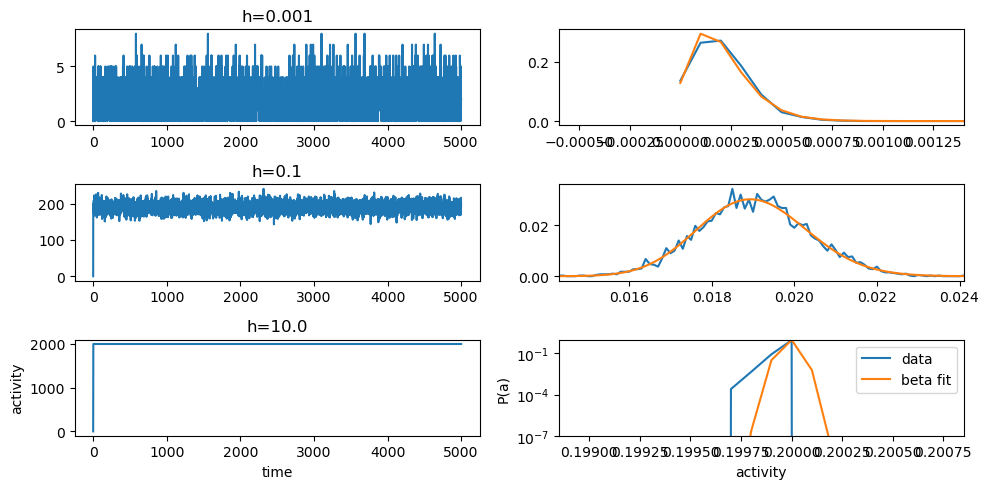

In [4]:
hs = [1e-3, 1e-1, 1e1]
fig, axes = plt.subplots(len(hs),2, figsize=(10,5))

N=int(1e4)
K=100
mu=0.2
lambda_ = 0.0
seed = 1000
w = coupling_weights(N, K, lambda_, seed)

T_meas = int(5e3)
T_burn = int(1e3)
activity = np.zeros(T_meas, dtype=np.float64)
rng = np.random.RandomState(seed)
x = np.random.randint(0,2,N)

delta = 1/N
support = np.linspace(0,1,N+1)

for (i,h_) in enumerate(hs):
    p_h = external_spiking_probability(N, mu, h_, seed)
    # simulation
    for t in tqdm(range(T_burn + T_meas)):
        x = step(x, w, p_h, rng)
        if t > T_burn:
            activity[t - T_burn] = np.sum(x)
    # plotting
    axes[i, 0].set_title(f'h={h_}')
    axes[i, 0].plot(activity, label='data')
    data = activity[1000:]/N
    # histogram needs bin edges but we work with bin centers, hence need to shift support
    pmf_data = np.histogram(data, bins=np.append(support,1+delta)-delta/2, density=False)[0]/len(data)
    axes[i, 1].plot(support, pmf_data, label='data')
    a,b,loc,scale = fit_beta_distribution(data, delta, seed)
    pmf_beta = stats.beta.pdf(support, a,b, loc=loc, scale=scale)
    pmf_beta = pmf_beta/np.sum(pmf_beta)
    axes[i, 1].plot(support, pmf_beta, label='beta fit')
    range_data = support[np.nonzero(pmf_data)]
    if len(range_data) > 10:
        axes[i, 1].set_xlim([range_data[0],range_data[-1]])
    else:
        axes[i, 1].set_xlim([np.median(range_data)-10*delta,np.median(range_data)+10*delta])

axes[len(hs)-1, 0].set_xlabel('time') 
axes[len(hs)-1, 0].set_ylabel('activity')
axes[len(hs)-1, 1].set_xlabel('activity')
axes[len(hs)-1, 1].set_ylabel('P(a)')
axes[len(hs)-1, 1].set_yscale('log')
axes[len(hs)-1, 1].set_ylim([1e-7,1])
axes[len(hs)-1, 1].legend()
    
plt.tight_layout()